In [25]:
# this cell is tagged parameters

PYLIB_DIR = None

########################
# inputs for quant-only
########################

# Reference info
REF_gtf_file = None
REF_quant_file = None

# Predictions
FLAMES_gtf_file = None
FLAMES_quant_file = None

IsoQuant_gtf_file = None
IsoQuant_quant_file = None

IsoSeq_gtf_file = None
IsoSeq_quant_file = None

LRAA_gtf_file = None
LRAA_quant_file = None

Mandalorion_gtf_file = None
Mandalorion_quant_file = None

Bambu_gtf_file = None
Bambu_quant_file = None

ESPRESSO_gtf_file = None
ESPRESSO_quant_file = None

FLAIR_gtf_file = None
FLAIR_quant_file = None

Isosceles_gtf_file = None
Isosceles_quant_file = None

StringTie_gtf_file = None
StringTie_quant_file = None

TALON_gtf_file = None
TALON_quant_file = None

In [26]:
# Parameters
IsoSeq_gtf_file = "raw_prog_results/sim_bulk_all.IsoSeq.ref-free.ID.gff"
Mandalorion_gtf_file = (
    "raw_prog_results/sim_bulk_all.Mandalorian.Isoforms.filtered.clean.gtf"
)
StringTie_quant_file = "processed_prog_results/stringtie.tsv"
IsoQuant_gtf_file = "raw_prog_results/sim_bulk_all.IsoQuant.gtf"
IsoSeq_quant_file = "processed_prog_results/IsoSeq.tsv"
LRAA_quant_file = "processed_prog_results/LRAA.tsv"
Bambu_quant_file = "processed_prog_results/bambu.tsv"
Bambu_gtf_file = "raw_prog_results/sim_bulk_all.Ref-Free.bambu.gtf"
StringTie_gtf_file = "raw_prog_results/sim_bulk_all.ref-free.stringtie.gtf"
IsoQuant_quant_file = "processed_prog_results/IsoQuant.tsv"
Mandalorion_quant_file = "processed_prog_results/Mandalorion.tsv"
LRAA_gtf_file = "processed_prog_results/LRAA.gtf"
PYLIB_DIR = "/home/bhaas/projects/LRAA_project/LRAA_PAPER_Analyses/iso-reconstruct-benchmark2/Isosceles_bmarking_routines/pylib"
REF_gtf_file = "reference_data/benchmark_full_annotations.wGene.gtf"
REF_quant_file = "reference_data/benchmark_transcript_expression.tab"
REF_reduced_gtf_file = None


In [27]:
import sys, os, re
sys.path.insert(0, PYLIB_DIR)


In [58]:
import BenchmarkingRoutines
from importlib import reload
reload(BenchmarkingRoutines)
from BenchmarkingRoutines import *

In [29]:
import warnings
warnings.filterwarnings('ignore')

In [59]:
set_color_palette("IsoQuant", "blue", "solid")
set_color_palette("IsoSeq", "orchid", "solid")
set_color_palette("LRAA", "teal", "solid")
set_color_palette("Mandalorion", "yellow", "solid")
set_color_palette("Bambu", "forestgreen", "solid")
set_color_palette("StringTie", "darkgray", "solid")

In [31]:
include_strand_in_intronId=False

i_ref_df = indexDfByIntronId(parseGTFtoIntronIDsandQuants(REF_gtf_file, 
                                                          REF_quant_file, 
                                                          include_strand_in_intronId=include_strand_in_intronId))
i_ref_df

-processGtf( reference_data/benchmark_full_annotations.wGene.gtf )



INFO:root:Extracted GTF attributes: ['gene_id', 'gene_name', 'transcript_id', 'gene_version', 'transcript_version', 'exon_number', 'gene_source', 'gene_biotype', 'transcript_name', 'transcript_source', 'transcript_biotype', 'exon_id', 'exon_version', 'tag', 'transcript_support_level', 'ccds_id']


,transcript_ids,gene_ids,tpm
intronId,,,
"10:100042573-100048757:?,10:100048876-100054346:?,10:100054446-100057012:?,10:100057152-100063613:?,10:100063725-100065187:?,10:100065370-100069713:?,10:100069869-100075910:?,10:100076107-100081402:?",ENST00000370418,ENSG00000120054,0.285346
"10:100152352-100154859:?,10:100154939-100156144:?,10:100156234-100164003:?,10:100164095-100167347:?,10:100167406-100174207:?,10:100174281-100175944:?,10:100176070-100178132:?,10:100178194-100179200:?,10:100179247-100183755:?,10:100183837-100185513:?",ENST00000421367,ENSG00000107566,72.049779
"10:100189627-100190868:?,10:100190968-100193297:?,10:100193431-100193983:?,10:100194131-100194424:?,10:100194521-100199970:?,10:100200020-100200670:?,10:100200780-100202087:?,10:100202149-100204505:?,10:100204657-100205075:?,10:100205199-100207229:?,10:100207332-100209594:?,10:100209789-100217994:?,10:100218130-100218717:?,10:100218825-100219007:?,10:100219132-100219269:?,10:100219359-100220587:?,10:100220676-100222111:?,10:100222181-100222865:?,10:100222980-100225922:?,10:100226017-100229427:?",ENST00000370397,ENSG00000213341,18.690141
"10:100233371-100235666:?,10:100235764-100236849:?,10:100236969-100238021:?,10:100238231-100243697:?,10:100243777-100245798:?,10:100245913-100246794:?,10:100246935-100250247:?,10:100250332-100253420:?,10:100253539-100256261:?,10:100256476-100260217:?,10:100260319-100260965:?,10:100261044-100261978:?,10:100262063-100267570:?",ENST00000354105,ENSG00000095485,25.966455
"10:100275493-100280123:?,10:100280228-100280933:?,10:100281053-100282905:?",ENST00000618916,ENSG00000196072,0.428018
...,...,...,...
"Y:12904414-12904934:?,Y:12904981-12907536:?,Y:12907594-12909359:?,Y:12909407-12911838:?,Y:12911968-12912726:?,Y:12912882-12912962:?,Y:12913062-12913717:?,Y:12913853-12914563:?,Y:12914649-12914883:?,Y:12914982-12915066:?,Y:12915227-12915629:?,Y:12915774-12915882:?,Y:12916027-12916260:?,Y:12916442-12916516:?,Y:12916634-12916906:?,Y:12917060-12917402:?,Y:12917542-12918042:?",ENST00000360160,ENSG00000067048,0.570691
"Y:20575887-20579607:?,Y:20579691-20582589:?,Y:20582693-20584473:?,Y:20584524-20588023:?,Y:20588105-20589483:?,Y:20589575-20592340:?",ENST00000361365,ENSG00000198692,0.285346
"Y:20575887-20579607:?,Y:20579691-20582589:?,Y:20582693-20588023:?,Y:20588105-20589483:?,Y:20589575-20592340:?",ENST00000382772,ENSG00000198692,0.285346


In [32]:
i_ref_df["tpm"] = i_ref_df["tpm"] / i_ref_df["tpm"].sum() * 1e6

In [33]:
i_ref_df.copy().reset_index().to_csv("refDf.intron_ids_and_expression.tsv", sep="\t", index=False)

In [34]:
ref_free_quant_dir = "processed_prog_results"
ref_free_gtf_dir = "raw_prog_results"

prog_quant_files = {  
    "IsoQuant" : [IsoQuant_quant_file, IsoQuant_gtf_file],
    "IsoSeq" : [IsoSeq_quant_file, IsoSeq_gtf_file],
    "LRAA" : [LRAA_quant_file, LRAA_gtf_file ],
    "Mandalorion" : [Mandalorion_quant_file, Mandalorion_gtf_file],
    "Bambu" : [Bambu_quant_file, Bambu_gtf_file],
    "StringTie" : [StringTie_quant_file, StringTie_gtf_file],
}

fullQuantsDf_dict = {}
for progname, (tsv_fname, gtf_fname) in prog_quant_files.items():
    
    print(progname, gtf_fname, tsv_fname)
    fullQuantsDf_dict[progname] = indexDfByIntronId(parseGTFtoIntronIDsandQuants(gtf_fname, tsv_fname, include_strand_in_intronId=include_strand_in_intronId))
    
progname_to_i_sample_df_dict_to_tsv(fullQuantsDf_dict, "progname_to_IntronId_expr_vals.tsv")

IsoQuant raw_prog_results/sim_bulk_all.IsoQuant.gtf processed_prog_results/IsoQuant.tsv
-processGtf( raw_prog_results/sim_bulk_all.IsoQuant.gtf )



INFO:root:Extracted GTF attributes: ['gene_id', 'transcripts', 'transcript_id', 'exons', 'exon_number', 'exon_id']
INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id']


IsoSeq raw_prog_results/sim_bulk_all.IsoSeq.ref-free.ID.gff processed_prog_results/IsoSeq.tsv
-processGtf( raw_prog_results/sim_bulk_all.IsoSeq.ref-free.ID.gff )

LRAA processed_prog_results/LRAA.gtf processed_prog_results/LRAA.tsv
-processGtf( processed_prog_results/LRAA.gtf )



INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id']


Mandalorion raw_prog_results/sim_bulk_all.Mandalorian.Isoforms.filtered.clean.gtf processed_prog_results/Mandalorion.tsv
-processGtf( raw_prog_results/sim_bulk_all.Mandalorian.Isoforms.filtered.clean.gtf )



INFO:root:Extracted GTF attributes: ['transcript_id', 'gene_id', 'gene_name']


Bambu raw_prog_results/sim_bulk_all.Ref-Free.bambu.gtf processed_prog_results/bambu.tsv
-processGtf( raw_prog_results/sim_bulk_all.Ref-Free.bambu.gtf )



INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'exon_number']


StringTie raw_prog_results/sim_bulk_all.ref-free.stringtie.gtf processed_prog_results/stringtie.tsv
-processGtf( raw_prog_results/sim_bulk_all.ref-free.stringtie.gtf )



INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'cov', 'FPKM', 'TPM', 'exon_number']


Bambu
[array([72.04977912, 18.69014072, 25.96645505, ...,  1.14138264,
        0.28534566,  4.2801849 ]), array([76.66885789, 24.25970537, 29.37778667, ...,  1.02361626,
        0.3354585 ,  5.20425853]), 'forestgreen']
IsoQuant
[array([72.04977912, 18.69014072, 25.96645505, ..., 16.6927211 ,
        1.14138264,  4.2801849 ]), array([75.27439884, 19.09819033, 24.60397494, ...,  1.37644615,
        0.86027884,  5.24770095]), 'blue']
IsoSeq
[array([1.09116180e+03, 1.09715406e+02, 1.06548069e+03, 6.01793997e+02,
       3.02609072e+02, 2.95618104e+02, 5.11196750e+02, 1.20858154e+03,
       5.52286525e+02, 7.27631433e+00, 5.77824961e+01, 6.48305339e+02,
       2.15007955e+02, 1.55099633e+03, 1.04864530e+02, 5.70691320e+01,
       8.63455967e+02, 1.39234415e+03, 1.57111320e+03, 1.09572733e+02,
       2.90624555e+03, 7.84700565e+00, 3.64015458e+03, 4.76812598e+02,
       1.04008493e+02, 2.45539940e+02, 1.76914309e+01, 1.20558541e+02,
       1.17990430e+02, 1.03723147e+03, 1.40761014e+03, 1.54

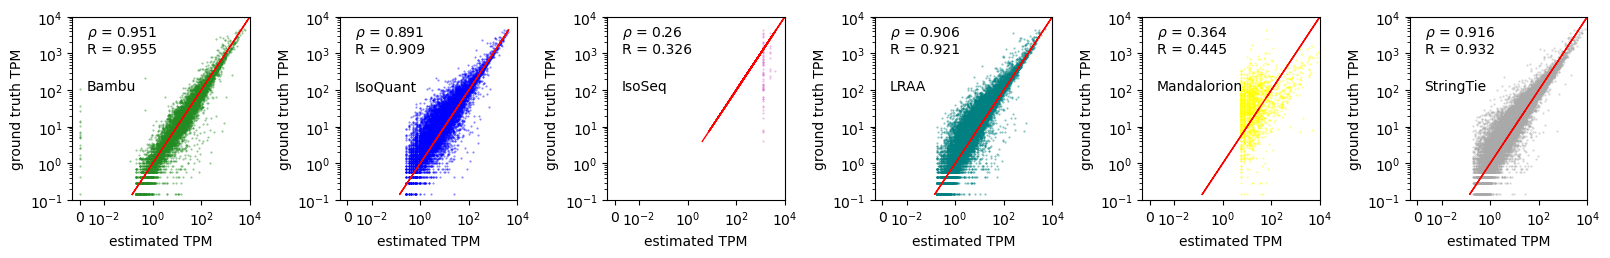

In [35]:
scatterplot_adj(i_ref_df, fullQuantsDf_dict)

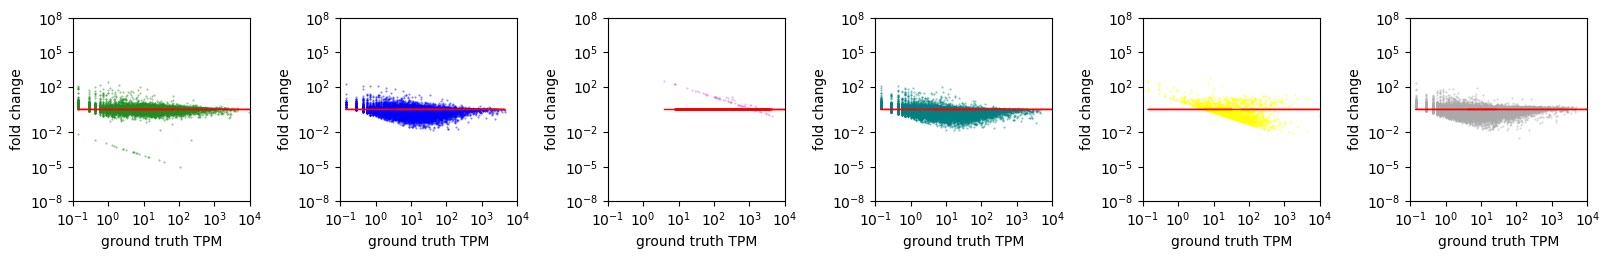

In [36]:
ma_plot_adj(i_ref_df, fullQuantsDf_dict)

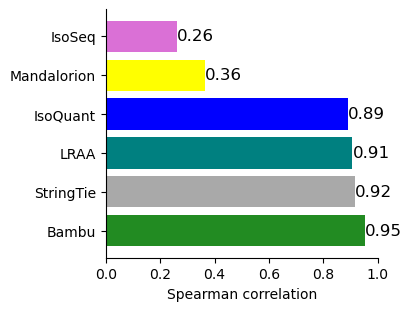

In [37]:
spearman_df = cor_spearman_barplot(i_ref_df, fullQuantsDf_dict)
spearman_df.to_csv("spearman_expr_cor.tsv", sep="\t", quoting=csv.QUOTE_NONE)

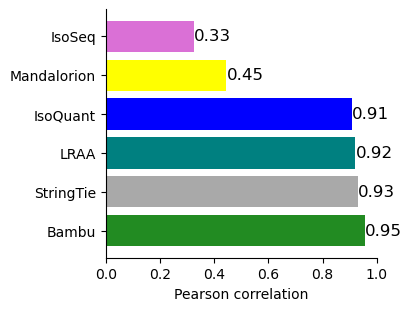

In [38]:
pearson_df = cor_pearson_barplot(i_ref_df, fullQuantsDf_dict)
pearson_df.to_csv("pearson_expr_cor.tsv", sep="\t", quoting=csv.QUOTE_NONE)

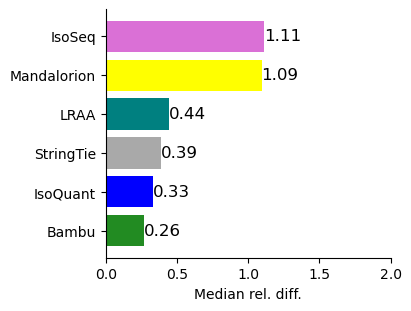

In [42]:
median_rel_diff_df = rel_diff_barplot(i_ref_df, fullQuantsDf_dict, 'median')
median_rel_diff_df.to_csv("median_rel_diff.tsv", sep="\t", quoting=csv.QUOTE_NONE)

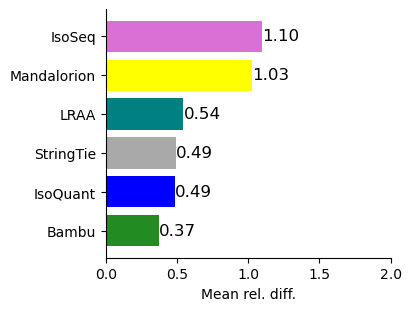

In [43]:
mean_rel_diff_df = rel_diff_barplot(i_ref_df, fullQuantsDf_dict, 'mean')
mean_rel_diff_df.to_csv("mean_rel_diff.tsv", sep="\t", quoting=csv.QUOTE_NONE)

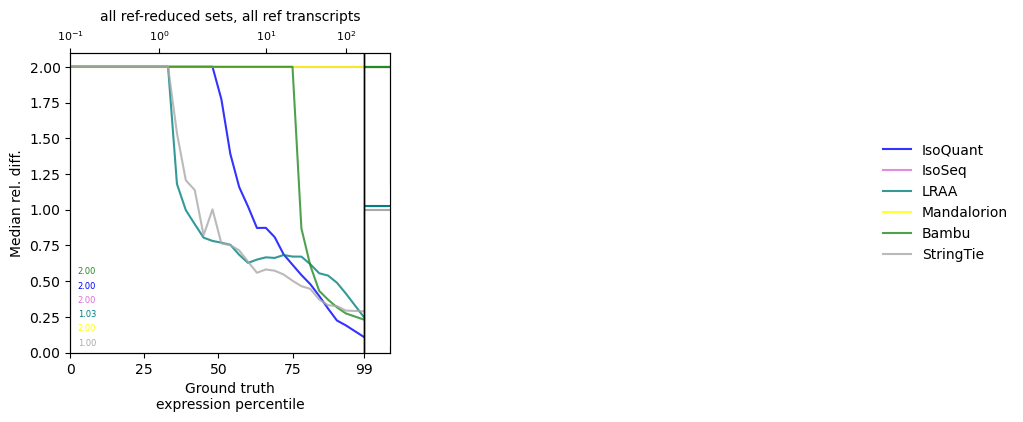

In [60]:
median_reldiffs_by_expr_percentile_df = rel_diff_vs_expr_percentile_plot(i_ref_df, fullQuantsDf_dict, 33, 'median',
                                 'all ref-reduced sets, all ref transcripts')

median_reldiffs_by_expr_percentile_df.to_csv("median_reldiffs_by_expr_percentile.tsv", sep="\t", quoting=csv.QUOTE_NONE)


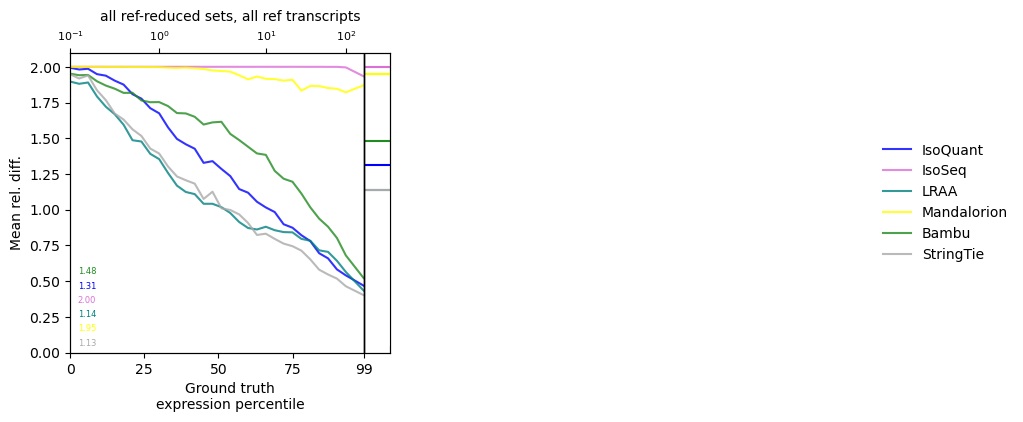

In [61]:
mean_reldiffs_by_expr_percentile_df = rel_diff_vs_expr_percentile_plot(i_ref_df, fullQuantsDf_dict, 33, 'mean',
                                 'all ref-reduced sets, all ref transcripts')
mean_reldiffs_by_expr_percentile_df.to_csv("mean_reldiffs_by_expr_percentile.tsv", sep="\t", quoting=csv.QUOTE_NONE)

In [ ]:
IsoformIdentificationSensitivityPlot(i_ref_df, fullQuantsDf_dict, 33, 
                                     'median', 'all transcripts set')


In [ ]:
full_transcriptome_TPR_FDR_F1_df = overall_knownTPR_novelTPR_and_FDR_barplot(i_ref_df, fullQuantsDf_dict)
full_transcriptome_TPR_FDR_F1_df.to_csv("full_transcriptome_TPR_FDR_F1.tsv", sep="\t", quoting=csv.QUOTE_NONE)

In [ ]:
TPR_F1_PPV_plot(i_ref_df, fullQuantsDf_dict)